Here you may get familiar with PU learning, play with mixtures of laplace and normal distributions, test DEDPUL and other methods.

The notebook is based on (Ivanov, 2018). Note that in the original paper proportions and posteriors of Positive class are presented and estimated, while methods in this notebook by default estimate those for Negative class. To convert, just substract the estimates from 1.

In [43]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace
import random

from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, brier_score_loss, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
from IPython import display

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

import warnings
warnings.filterwarnings('ignore')

# What is PU learning?

Positive-Unlabeled (PU) Classification is a problem of semi-supervised learning on the data that is corrupted in a specific way. Unlike supervised binary classification, PU classification does not require labeled samples from both classes for training. Instead, two samples are required: a labeled sample from Positive (P) class, and an Unlabeled (U) sample with mixed data from both Positive (P) and Negative (N) classes with generally unknown mixing proportions. The objectives are: (i) to estimate the proportions of P and N in U and (ii) to classify it, i.e. to assign probability of being P rather than N for each instance in U. The first problem is reffered to as Mixture Proportions Estimation; the second - as PU Classification.

Several methods that solve these problems are highlighted in this notebook.

# Data

In [44]:
# specify distributions to sample data from.

mode = 'normal'
# mode ='laplace'

In [84]:
# feel free to play with parameters of distributions;
# initially we recommend to stick to cases of either mu1=mu2 or s1=s2

# centers and standard deviations of P and N distributions
mu1 = 0
s1 = 1
mu2 = 4
s2 = 1

# alpha is proportion of N in U; (1 - alpha) is proportion of P in U; these will be unknown for methods below;
# note that not alpha but alpha^* (computed below) is the proportion that the methods are supposed to identify 
# (find out why in the paper)
alpha = 0.75

if mode == 'normal':
    p1 = lambda x: norm.pdf(x, mu1, s1)
    p2 = lambda x: norm.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha
elif mode == 'laplace':
    p1 = lambda x: laplace.pdf(x, mu1, s1)
    p2 = lambda x: laplace.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha

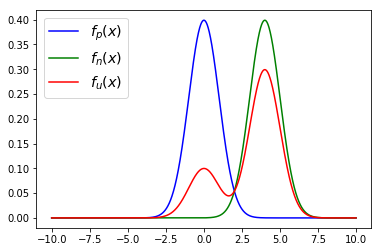

In [85]:
# These are the distributions.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot([x/100 for x in range(-1000, 1000)], [pm(x/100) for x in range(-1000, 1000)], 'r')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='r')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f_u(x)$'),
          fontsize='x-large')

Lets generate samples from the Positive and the Unlabeled distributions $f_p(x)$ and $f_u(x)$. Remember, we don't have Negative data from $f_n(x)$.

In [86]:
if mode == 'normal':
    sampler = np.random.normal
elif mode == 'laplace':
    sampler = np.random.laplace

In [87]:
mix_size =2500
pos_size = 500

mix_data_test = np.append(sampler(mu1, s1, int(mix_size * (1 - alpha))), 
                          sampler(mu2, s2, int(mix_size * alpha)))
pos_data_test = sampler(mu1, s1, int(pos_size))

data_test = np.append(mix_data_test, pos_data_test).reshape((-1, 1))
target_test = np.append(np.array([1] * mix_size), np.array([0] * pos_size))
target_test_true = np.append(np.array([0] * int(mix_size * (1 - alpha))), np.array([1] * int(mix_size * alpha)))
target_test_true = np.append(target_test_true, np.array([2] * pos_size))

mix_data_test = mix_data_test.reshape([-1, 1])
pos_data_test = pos_data_test.reshape([-1, 1])

data_test = np.concatenate((data_test, target_test.reshape(-1, 1), target_test_true.reshape(-1, 1)), axis=1)
np.random.shuffle(data_test)
target_test = data_test[:, 1]
target_test_true = data_test[:, 2]
data_test = data_test[:, 0].reshape(-1, 1)

In [88]:
# here we may estimate ground truth alpha^* for limited number of cases: 
# laplace and normal distributions where either mean or std coincide.
# alpha^* is the desired proportion that the methods are supposed to identify.

cons_alpha = estimate_cons_alpha(mu2 - mu1, s2 / s1, alpha, mode)
print('alpha* =', cons_alpha)

alpha* = 0.75


# DEDPUL

The short way:

In [112]:
test_alpha, poster = estimate_poster_cv(data_test, target_test, estimator='dedpul', alpha=None,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={'tune': True,
                                                                'tune_diff_options': {'max_evals': 20, 'verbose': False,
                                                                                      'bw_mix_l': 0.01, 'bw_mix_h': 0.15, 
                                                                                      'bw_pos_l': 0.05, 'bw_pos_h': 0.25,
                                                                                      'threshold_l': 0.55, 'threshold_h': 0.55,
                                                                                      'k_neighbours_l': 100, 
                                                                                      'k_neighbours_h': 500,
                                                                                      'metric': brier_score_loss, 
                                                                                      'if_round': False,
                                                                                      'reweight': False}},
                                         estimate_preds_cv_options={'cv': 3, 'n_networks': 10,
                                                                    'lr': 0.0005, 'hid_dim': 32,
                                                                    'n_hid_layers': 1, 
                                                                    'random_state': 0},
                                         train_nn_options={'n_epochs': 100, 'batch_size': 16,
                                                           'n_batches': 15, 'n_early_stop': 3, 'disp': False})

print('alpha:', test_alpha, '\nerror:', abs(test_alpha - cons_alpha))

alpha: 0.7457509794745755 
error: 0.0042490205254245295


The long way:

In [93]:
# estimate y(x), the predictions of NTC

preds = estimate_preds_cv(data_test, target_test, n_networks=10,
                          train_nn_options={'n_epochs': 200, 'batch_size': 16,
                                            'n_batches': 15, 'n_early_stop': 3, 'disp': False, 'loss_function': 'log'})

print('ac', accuracy_score(target_test, preds.round()))
print('brier', brier_score_loss(target_test, preds))
print('roc', roc_auc_score(target_test, preds))

ac 0.7873333333333333
brier 0.14569259496297102
roc 0.8691191999999999


In [94]:
bw_mix = 0.05
bw_pos = 0.15
threshold = 0.55
k_neighbours = 125

In [95]:
# estimate density ratio g_p(y)/g_u(y) with tuned bandwidths, apply heuristics

diff = estimate_diff(preds, target_test, bw_mix, bw_pos, 'logit', threshold, k_neighbours,
#                      tune=False, tune_diff_options=None)
                     tune=True, tune_diff_options={'max_evals': 20, 'verbose': True,
                                                   'bw_mix_l': 0.01, 'bw_mix_h': 0.15, 
                                                   'bw_pos_l': 0.05, 'bw_pos_h': 0.25,
                                                   'threshold_l': 0.55, 'threshold_h': 0.55,
                                                   'k_neighbours_l': 100, 'k_neighbours_h': 500,
                                                   'metric': brier_score_loss, 'if_round': False})

best params: 0.0602 0.2452 0.55 372


In [96]:
# plt.plot(preds[target_test==1], diff, 'bo')

In [111]:
# Estimate priors alpha^* and posteriors f^*(p | x) with EM algorithm (if converges) 
# or with alternative max_slope otherwise

test_alpha, poster = estimate_poster_em(diff, mode='dedpul', converge=True, nonconverge=True, 
                                        max_diff=0.05, step=0.0025) # , alpha=cons_alpha
print('alpha:', test_alpha, '\nerror:', abs(test_alpha - cons_alpha))

alpha: 0.7457509794745755 
error: 0.0042490205254245295


Text(0.5,0,'$y(x)$')

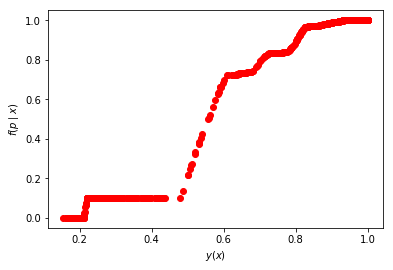

In [98]:
plt.plot(preds[target_test==1], poster, 'ro')
plt.ylabel('$f(p \mid x)$')
plt.xlabel('$y(x)$')

Analyze results:

In [91]:
# compute performance measures

realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                    data_test[target_test_true != 2].reshape(-1,))
realistic_poster[realistic_poster < 0] = 0

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], poster))
print('true MAE:',
      mean_absolute_error(realistic_poster, poster))
print('true RMSE:',
      np.sqrt(mean_squared_error(realistic_poster, poster)))

accuracy: 0.9808
ROC-AUC: 0.9963310933333333
brier: 0.016009623250151348
true MAE: 0.009580895002702471
true RMSE: 0.03481760929199832


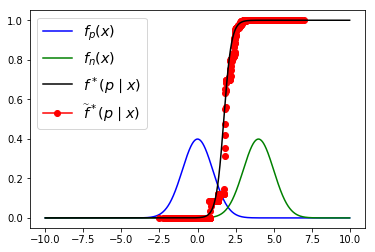

In [92]:
# illustrate performance graphically. The closer red circles to black line - the better.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0)
                                               for x in range(-1000, 1000)], 'k')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='k'),
                        Line2D([], [], color='r', marker='o')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f^*(p \mid x)$', '$\widetilde{f}^*(p \mid x)$'),
          fontsize='x-large')

In [83]:
# # illustrate max_slope: the highest point on the second graph is the estimate \alpha_n^*

# posters = []
# step = 0.005
# for test_alpha_ in np.arange(0, 1+step, step):
#     poster_ = 1 - diff * (1 - test_alpha_)
#     poster_[poster_ < 0] = 0
#     posters.append(np.mean(poster_) - test_alpha_)


# fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6, 10))
# axs[0].plot(np.arange(0, 1+step, step), posters)
# axs[1].plot(np.arange(2*step, 1+step, step), np.diff(np.diff(posters)))

# EN

In [99]:
# EN_alpha, EN_poster = estimate_poster_en(preds, target_test, alpha=None, estimator='e3', e3_quantile=0.95)

EN_alpha, EN_poster = estimate_poster_em(preds=preds, target=target_test, mode='en', converge=True, nonconverge=True, 
                                         max_diff=0.05, step=0.0025)

print('EN priors =', EN_alpha)
print('EN posters mean =', np.mean(EN_poster))
print()

EN_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], EN_poster.round()))
print('bac:', 
      balanced_accuracy_score(target_test_true[target_test_true != 2], EN_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], EN_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], EN_poster.round()))
print('MAE:',
      mean_absolute_error(EN_realistic_poster, EN_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(EN_realistic_poster, EN_poster)))

EN priors = 0.7679460044148877
EN posters mean = 0.7679539011388046

accuracy: 0.9688
bac: 0.9429333333333334
ROC-AUC: 0.9966911999999999
brier: 0.0312
MAE: 0.02314218976508471
RMSE: 0.07080016027777604


(0, 1)

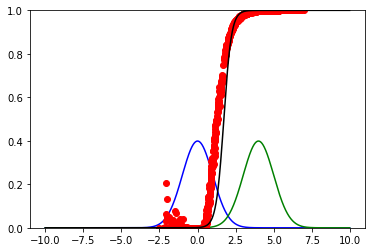

In [100]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], EN_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# nnRE

In [101]:
nnre_poster = estimate_preds_cv(data_test, target_test, n_networks=1, training_mode='nnre', alpha=cons_alpha,
                          train_nn_options={'n_epochs': 50, 'batch_size': 16, 'loss_function': 'brier',
                                            'n_batches': 15, 'n_early_stop': 10, 'disp': False})[target_test == 1]


nnre_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], nnre_poster.round()))
print('bac:', 
      balanced_accuracy_score(target_test_true[target_test_true != 2], nnre_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], nnre_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], nnre_poster.round()))
print('MAE:',
      mean_absolute_error(nnre_realistic_poster, nnre_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(nnre_realistic_poster, nnre_poster)))

accuracy: 0.9768
bac: 0.9626666666666667
ROC-AUC: 0.9966208000000001
brier: 0.0232
MAE: 0.03753871459682374
RMSE: 0.06117715419803298


(0, 1)

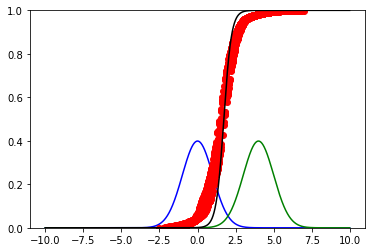

In [102]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2].flatten(), nnre_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# KM Proportions Estimation

implementation is taken from http://web.eecs.umich.edu/~cscott/code.html#kmpe

In [22]:
# KM_1, KM_2 = wrapper(mix_data_test, pos_data_test, epsilon=0.04, lambda_lower_bound=0.5, lambda_upper_bound=10, 
#                      KM_1=True, KM_2=True)
# KM_1 = 1 - KM_1
# KM_2 = 1 - KM_2

# print(KM_1)
# print(KM_2)